## Import Module

In [1]:
import struct
import numpy as np
import pandas as pd
# import import_ipynb
from importnb import Notebook
with Notebook(): 
    import NN_HW3_sm as NN
    import CNN_pool_class as CNN
from tqdm import tqdm, trange, notebook
from matplotlib import pyplot as plt
np.seterr(all='raise')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

## Read Data Function

In [2]:
def read_data(image_dir, label_dir):
    with open(image_dir, 'rb') as file:
        magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
        
        buf = file.read(size * rows * cols)
        img_data = np.frombuffer(buf, dtype=np.uint8).astype(np.float64)
        img_data = img_data.reshape(size, 1, rows, cols)
        img_data = img_data / 255
        
    
    with open(label_dir, 'rb') as file:
        magic, size = struct.unpack(">II", file.read(8))
        
        buf = file.read(size)
        lab_data_tmp = np.frombuffer(buf, dtype=np.uint8).astype(np.uint16)
        lab_data_tmp = lab_data_tmp.reshape(size)
        
#     print(lab_data[0:111])
    lab_data = np.zeros((size, 10), dtype=np.uint16)
    for i in range(size):
        lab_data[i][ lab_data_tmp[i] ] = 1
    
#     print(lab_data[0:10])
    
    
    return img_data.copy(), lab_data.copy()

In [3]:
# print(np.frombuffer(b'\x02\x01\x00\x00', dtype=np.uint16))
train_data, train_label  = read_data('./MNIST/train-images-idx3-ubyte', './MNIST/train-labels-idx1-ubyte')
test_data, test_label  = read_data('./MNIST/t10k-images-idx3-ubyte', './MNIST/t10k-labels-idx1-ubyte')

In [4]:
print((train_data[0]))

[[[0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.        ]
  [0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.        ]
  [0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.        ]
  [0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
  

## Dataset Label

In [5]:
def preprocess_input(x):
    return x

ans = preprocess_input(train_data[0])
ans1 = preprocess_input(test_data[1])
print(ans)
print(ans1)
# print(train_data[0:10])

[[[0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.        ]
  [0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.        ]
  [0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.        ]
  [0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
  

In [6]:

def construct_model(model):
    #### First Convolution + pooling
    # func, d_func, last_layer, input_size, input_num, filter_size, filter_num, stride
    model.layer_list.append( CNN.ConvLayer(NN.Sigmoid, NN.d_Sigmoid, 1, input_size=28, input_num=1, filter_size=5, filter_num=3, stride=1, is_first=True))
    # last_layer, input_size, input_num, filter_size, stride
    model.layer_list.append( CNN.AvgPooling(model.layer_list[len(model.layer_list)-1], input_size=24, input_num=3, filter_size=4, stride=2, is_first=False))   
    
    #### Second Convolution + pooling
    # func, d_func, last_layer, input_size, input_num, filter_size, filter_num, stride
    model.layer_list.append( CNN.ConvLayer(NN.ReLU, NN.d_ReLU, model.layer_list[len(model.layer_list)-1], input_size=11, input_num=1, filter_size=3, filter_num=5, stride=1, is_first=False))
    # last_layer, input_size, input_num, filter_size, stride
    model.layer_list.append( CNN.AvgPooling(model.layer_list[len(model.layer_list)-1], input_size=model.layer_list[len(model.layer_list)-1].get_output_size(), input_num=5, filter_size=3, stride=1, is_first=False))       
    
    # last_layer, input_size, input_num
    model.layer_list.append( CNN.Flattening(model.layer_list[len(model.layer_list)-1], input_size=model.layer_list[len(model.layer_list)-1].get_output_size(), input_num=5, is_first=False))
    
    #### First MLP
    # func, d_func, node_num, last_layer, is_first
    model.layer_list.append( NN.Layer_vec(NN.ReLU, NN.d_ReLU, 100, model.layer_list[len(model.layer_list)-1], False) )
    
    #### Second MLP
    # func, d_func, node_num, last_layer, is_first
    model.layer_list.append( NN.Layer_vec(NN.ReLU, NN.d_ReLU, 64, model.layer_list[len(model.layer_list)-1], False) )
    
    #### Third MLP
    # func, d_func, node_num, last_layer, is_first
    model.layer_list.append( NN.Layer_vec(NN.ReLU, NN.d_ReLU, 10, model.layer_list[len(model.layer_list)-1], False) )
    
    #### Output Layer
    model.layer_list.append( NN.Softmax_Output(model.layer_list[len(model.layer_list)-1]) )
    print(model.layer_list)
            

In [7]:
##############################################################
#                         MODEL block                        #
##############################################################

# with Notebook(): 
#     import NN_HW3_sm as NN
# lr_rate = 0.00009
epochs = 500

lr_rate = 0.0001
layer_nums = [20, 20, 20, 10]
# layer_nums = [train_data.shape[1]-1, 7, 1]
layer_input = preprocess_input(train_data[0])
test_m = NN.Model(layer_nums, construct_model, layer_input, lr_rate)

train_loss = []
test_loss = []
train_acc = []
test_acc = []
output_node_w = [[]]
output_node_w = np.array([test_m.get_output_w()])

for epoch in range(epochs):
    train_err_cnt = 0
    train_error = []
    print(epoch+1, "/", epochs, "epochs")
    train_progress = notebook.tqdm(total=len(train_data), desc="Training")
    test_progress = notebook.tqdm(total=len(test_data), desc="Testing")
    for i, input_data in enumerate(train_data):
#     for i, input_data in enumerate(train_data[0:100]):
#         print(i, "'s data !!!")
#         print(input_data)
        train_progress.update(1)
        p_data = preprocess_input(input_data)
        test_m.cal_network(p_data)
        ans_conf = test_m.get_result()
        ans = np.argmax(ans_conf)
        std = np.argmax(train_label[i])
        if ans != std:
            train_err_cnt += 1
        
        # Adjust model weights
        p_loss = test_m.adjust_model(train_label[i])
#         print(p_loss)
        train_error.append(p_loss)
#         print("ans_conf:　", ans_conf, "ans: ", ans, "train_label[i]:　", train_label[i], "std: ", std, "p_loss: ", p_loss)
#         print(test_m.get_output_w())
    output_node_w = np.append(output_node_w, [test_m.get_output_w()], 0)
        
    train_loss.append(np.average(train_error))
    train_acc.append(1 - train_err_cnt/len(train_data) )
    print("Train loss: ", np.average(train_error), ", acc = ", (1-train_err_cnt/len(train_data)) * 100, "%")
    test_err_cnt = 0
    test_error = []
    for i, input_data in enumerate(test_data):
#     for i, input_data in enumerate(test_data[0:10]):
        # print(i, "'s data !!!")
        test_progress.update(1)
        
        p_data = preprocess_input(input_data)
        test_m.cal_network(p_data)
        ans_conf = test_m.get_result()
        ans = np.argmax(ans_conf)
        std = np.argmax(test_label[i])
        if ans != std:
            test_err_cnt += 1
        
        
        p_loss = test_m.get_loss(test_label[i])
        test_error.append(p_loss)
        
        
    test_loss.append(np.average(test_error))
    test_acc.append(1 - test_err_cnt/len(test_data) )
    print("Test loss: ", np.average(test_error), ", acc = ", (1-test_err_cnt/len(test_data)) * 100, "%")
    print()
test_m.get_loss()

[<CNN_pool_class.ConvLayer object at 0x0000023385C30630>, <CNN_pool_class.AvgPooling object at 0x0000023385C306D8>, <CNN_pool_class.ConvLayer object at 0x0000023385C30710>, <CNN_pool_class.AvgPooling object at 0x0000023385C30748>, <CNN_pool_class.Flattening object at 0x0000023385C30780>, <NN_HW3_sm.Layer_vec object at 0x0000023385C307B8>, <NN_HW3_sm.Layer_vec object at 0x0000023385C307F0>, <NN_HW3_sm.Layer_vec object at 0x0000023385C30828>, <NN_HW3_sm.Softmax_Output object at 0x0000023385C30860>]
1 / 500 epochs


Train loss:  2.1296969138870234 , acc =  25.61 %
Test loss:  1.488589884674032 , acc =  57.21000000000001 %

2 / 500 epochs


Train loss:  0.9932064878909923 , acc =  69.455 %
Test loss:  0.8642037673480616 , acc =  72.05 %

3 / 500 epochs




Train loss:  0.7518690592496282 , acc =  75.575 %
Test loss:  0.730867750536015 , acc =  75.52 %

4 / 500 epochs


Train loss:  0.6659346889073855 , acc =  77.94 %
Test loss:  0.6613945512347301 , acc =  77.27999999999999 %

5 / 500 epochs


Train loss:  0.6104015522136557 , acc =  79.415 %
Test loss:  0.6232937748956513 , acc =  78.3 %

6 / 500 epochs


Train loss:  0.5699574092009233 , acc =  80.54666666666667 %
Test loss:  0.5910500528069711 , acc =  79.21000000000001 %

7 / 500 epochs


Train loss:  0.5402095462937154 , acc =  81.375 %
Test loss:  0.5644017595572913 , acc =  80.04 %

8 / 500 epochs


Train loss:  0.5169524346551261 , acc =  82.01499999999999 %
Test loss:  0.5439432065212146 , acc =  80.83 %

9 / 500 epochs


Train loss:  0.386132803452877 , acc =  87.37833333333333 %
Test loss:  0.3068055307874254 , acc =  90.29 %

10 / 500 epochs


Train loss:  0.275005617532972 , acc =  91.57666666666667 %
Test loss:  0.2813225507363973 , acc =  90.9 %

11 / 500 epochs


Train loss:  0.2558835198034831 , acc =  92.145 %
Test loss:  0.27013538171624457 , acc =  91.17999999999999 %

12 / 500 epochs


Train loss:  0.24191336907935168 , acc =  92.52666666666667 %
Test loss:  0.26177949417468854 , acc =  91.16 %

13 / 500 epochs


Train loss:  0.23043664823015986 , acc =  92.85 %
Test loss:  0.24909126727133216 , acc =  91.56 %

14 / 500 epochs


Train loss:  0.22091369006406497 , acc =  93.075 %
Test loss:  0.24298568926544545 , acc =  91.83 %

15 / 500 epochs


Train loss:  0.2129835539690865 , acc =  93.31833333333334 %
Test loss:  0.23673471712884506 , acc =  92.13 %

16 / 500 epochs


Train loss:  0.20621734273360054 , acc =  93.49 %
Test loss:  0.23065326746480963 , acc =  92.45 %

17 / 500 epochs


Train loss:  0.20029973939282036 , acc =  93.67999999999999 %
Test loss:  0.22903335287899249 , acc =  92.36999999999999 %

18 / 500 epochs


Train loss:  0.1951295268096612 , acc =  93.85166666666666 %
Test loss:  0.2223883655568711 , acc =  92.66 %

19 / 500 epochs


Train loss:  0.1902107748154982 , acc =  93.97166666666666 %
Test loss:  0.2169307617552196 , acc =  92.83 %

20 / 500 epochs


Train loss:  0.18581953299397422 , acc =  94.09333333333333 %
Test loss:  0.21261959196797306 , acc =  92.91 %

21 / 500 epochs








Train loss:  0.18200634720074185 , acc =  94.21000000000001 %
Test loss:  0.20776736792774378 , acc =  93.06 %

22 / 500 epochs


Train loss:  0.1782156766218744 , acc =  94.315 %
Test loss:  0.20375222457658645 , acc =  93.28999999999999 %

23 / 500 epochs


Train loss:  0.17473970305503675 , acc =  94.40166666666666 %
Test loss:  0.20205160294214883 , acc =  93.36 %

24 / 500 epochs


Train loss:  0.1714151094558319 , acc =  94.49666666666666 %
Test loss:  0.19850596759592487 , acc =  93.5 %

25 / 500 epochs


Train loss:  0.16828028483361057 , acc =  94.6 %
Test loss:  0.19606951821902258 , acc =  93.55 %

26 / 500 epochs


Train loss:  0.1654451039208512 , acc =  94.675 %
Test loss:  0.1938744075998486 , acc =  93.57 %

27 / 500 epochs


Train loss:  0.16269720529311987 , acc =  94.82333333333334 %
Test loss:  0.19133834458277796 , acc =  93.82000000000001 %

28 / 500 epochs


Train loss:  0.16006348893487643 , acc =  94.86333333333333 %
Test loss:  0.19059191248037788 , acc =  93.87 %

29 / 500 epochs


Train loss:  0.1574004594882623 , acc =  94.95333333333333 %
Test loss:  0.18808076723337422 , acc =  93.92 %

30 / 500 epochs


Train loss:  0.15481775770793108 , acc =  95.04333333333334 %
Test loss:  0.1852329537043724 , acc =  94.05 %

31 / 500 epochs


Train loss:  0.15261571799629228 , acc =  95.08166666666666 %
Test loss:  0.18187441638229698 , acc =  94.08999999999999 %

32 / 500 epochs


Train loss:  0.15050478333140907 , acc =  95.15666666666667 %
Test loss:  0.180594299478838 , acc =  94.11 %

33 / 500 epochs


Train loss:  0.1482738579440562 , acc =  95.21333333333332 %
Test loss:  0.178245255572392 , acc =  94.17 %

34 / 500 epochs


Train loss:  0.14638295597094841 , acc =  95.31166666666667 %
Test loss:  0.1769294571707164 , acc =  94.26 %

35 / 500 epochs


Train loss:  0.1445036711812731 , acc =  95.35166666666667 %
Test loss:  0.1754939346549242 , acc =  94.19999999999999 %

36 / 500 epochs


Train loss:  0.14240796895468855 , acc =  95.42666666666668 %
Test loss:  0.17393784930725703 , acc =  94.31 %

37 / 500 epochs































Train loss:  0.14048186662281542 , acc =  95.49 %
Test loss:  0.17174879159782583 , acc =  94.39 %

38 / 500 epochs


Train loss:  0.1388090580697548 , acc =  95.565 %
Test loss:  0.17208770601636278 , acc =  94.36 %

39 / 500 epochs


Train loss:  0.13699747969741857 , acc =  95.62166666666667 %
Test loss:  0.17001149305222485 , acc =  94.5 %

40 / 500 epochs


Train loss:  0.13545122870955575 , acc =  95.68166666666667 %
Test loss:  0.17070142094422366 , acc =  94.51 %

41 / 500 epochs


Train loss:  0.13381828237544602 , acc =  95.735 %
Test loss:  0.1671629125712931 , acc =  94.58 %

42 / 500 epochs


Train loss:  0.1323152742345908 , acc =  95.825 %
Test loss:  0.16543506150986784 , acc =  94.66 %

43 / 500 epochs


Train loss:  0.13086809437162694 , acc =  95.84333333333333 %
Test loss:  0.16772410738149096 , acc =  94.55 %

44 / 500 epochs


Train loss:  0.12931169490132954 , acc =  95.89833333333333 %
Test loss:  0.16498722585077133 , acc =  94.64 %

45 / 500 epochs


Train loss:  0.12792001327564206 , acc =  95.94500000000001 %
Test loss:  0.1647570338092801 , acc =  94.69 %

46 / 500 epochs


Train loss:  0.1266423708917278 , acc =  95.965 %
Test loss:  0.1651515092733259 , acc =  94.66 %

47 / 500 epochs


Train loss:  0.12525134853878284 , acc =  96.00666666666666 %
Test loss:  0.16367733028385326 , acc =  94.72 %

48 / 500 epochs


Train loss:  0.1239374112932705 , acc =  96.07166666666667 %
Test loss:  0.16264896032087614 , acc =  94.82000000000001 %

49 / 500 epochs


Train loss:  0.12273017189686118 , acc =  96.09666666666666 %
Test loss:  0.16421964866828492 , acc =  94.72 %

50 / 500 epochs


Train loss:  0.12142526757154966 , acc =  96.12 %
Test loss:  0.16158008309680533 , acc =  94.92 %

51 / 500 epochs


Train loss:  0.12028692778546146 , acc =  96.16666666666667 %
Test loss:  0.16116793403387855 , acc =  94.88 %

52 / 500 epochs


Train loss:  0.11925400020921988 , acc =  96.19 %
Test loss:  0.1587771113690606 , acc =  94.99 %

53 / 500 epochs


Train loss:  0.118177261057844 , acc =  96.20833333333333 %
Test loss:  0.1576299549947495 , acc =  95.05 %

54 / 500 epochs


Train loss:  0.1171558023227577 , acc =  96.25166666666667 %
Test loss:  0.15810360231009193 , acc =  95.02000000000001 %

55 / 500 epochs


Train loss:  0.11622752060896215 , acc =  96.30499999999999 %
Test loss:  0.1583806343218436 , acc =  95.05 %

56 / 500 epochs


Train loss:  0.11517169459058 , acc =  96.345 %
Test loss:  0.15748650907341072 , acc =  95.11 %

57 / 500 epochs


Train loss:  0.11430855080813325 , acc =  96.395 %
Test loss:  0.15721419996343156 , acc =  95.16 %

58 / 500 epochs


Train loss:  0.11337505986430746 , acc =  96.39666666666666 %
Test loss:  0.15674408030268733 , acc =  95.15 %

59 / 500 epochs


Train loss:  0.11243465193147147 , acc =  96.45666666666666 %
Test loss:  0.1567188504498611 , acc =  95.17 %

60 / 500 epochs


Train loss:  0.11146665199726782 , acc =  96.47666666666666 %
Test loss:  0.15720813397299502 , acc =  95.13000000000001 %

61 / 500 epochs


Train loss:  0.11070603920077056 , acc =  96.48 %
Test loss:  0.1559220132635426 , acc =  95.13000000000001 %

62 / 500 epochs


Train loss:  0.10979349739883916 , acc =  96.51833333333333 %
Test loss:  0.15558135182358188 , acc =  95.17 %

63 / 500 epochs


Train loss:  0.10868748193964375 , acc =  96.55166666666666 %
Test loss:  0.1553510077239764 , acc =  95.15 %

64 / 500 epochs


Train loss:  0.10811202492072418 , acc =  96.55333333333334 %
Test loss:  0.15524835505067416 , acc =  95.22 %

65 / 500 epochs


Train loss:  0.10710917887757114 , acc =  96.58666666666666 %
Test loss:  0.1561844097386424 , acc =  95.25 %

66 / 500 epochs


Train loss:  0.10641116773934328 , acc =  96.64 %
Test loss:  0.1578821870236855 , acc =  95.22 %

67 / 500 epochs


Train loss:  0.10549892135188599 , acc =  96.65166666666667 %
Test loss:  0.15679620445707104 , acc =  95.14 %

68 / 500 epochs


Train loss:  0.10469031232320938 , acc =  96.66166666666666 %
Test loss:  0.15697424231742269 , acc =  95.23 %

69 / 500 epochs


Exception in thread Thread-6:
Traceback (most recent call last):
  File "D:\anaconda3\envs\nn_class\lib\threading.py", line 917, in _bootstrap_inner
    self.run()
  File "D:\anaconda3\envs\nn_class\lib\site-packages\tqdm\_monitor.py", line 68, in run
    instances = self.get_instances()
  File "D:\anaconda3\envs\nn_class\lib\site-packages\tqdm\_monitor.py", line 48, in get_instances
    return [i for i in self.tqdm_cls._instances.copy()
  File "D:\anaconda3\envs\nn_class\lib\_weakrefset.py", line 92, in copy
    return self.__class__(self)
  File "D:\anaconda3\envs\nn_class\lib\_weakrefset.py", line 50, in __init__
    self.update(data)
  File "D:\anaconda3\envs\nn_class\lib\_weakrefset.py", line 119, in update
    for element in other:
  File "D:\anaconda3\envs\nn_class\lib\_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



Train loss:  0.10392514540188322 , acc =  96.71499999999999 %
Test loss:  0.1576617771857025 , acc =  95.17 %

70 / 500 epochs


Train loss:  0.10323741319423167 , acc =  96.72166666666666 %
Test loss:  0.1588021195891132 , acc =  95.19999999999999 %

71 / 500 epochs


KeyboardInterrupt: 

In [8]:
print("Train loss: ", (train_error))

Train loss:  [0.07435334247695953, 1.6624162329990682e-05, 0.0006353161527376835, 3.504060773618658e-05, 0.00010334205440650706, 0.0003750468280560597, 0.0001316353049700204, 0.0001151655196965289, 0.00023327799001165365, 3.2243947925326486e-05, 0.0009854093495918301, 0.004771378453171085, 9.765934471688206e-08, 0.001141763031213616, 0.00026607789042456756, 0.003933370871920245, 5.871663736579751e-05, 0.000131967043377812, 0.9204988251623251, 0.002580445190754165, 6.569906309868106e-05, 0.000722426622348257, 0.032000759995837846, 3.8978350029753065e-05, 0.007721410806042894, 0.23426917371893535, 0.0017385206897383902, 7.425130278348054e-07, 0.005000309489310646, 1.68711468460389, 0.00555202511080634, 0.0010558605819464624, 5.363479399694503e-05, 0.001346268307780664, 2.2690379485067266e-05, 0.003912646820217471, 0.001400799476824498, 2.1601908275336197e-05, 0.02836566220220141, 0.0008575205595879374, 2.2705147743265488e-05, 0.001335880591644911, 0.003661561535232731, 0.0006495803304999

Text(0, 0.5, 'value')

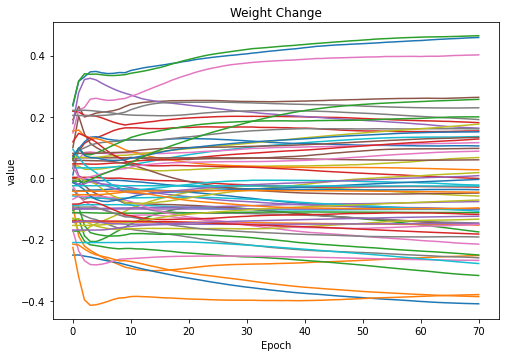

In [9]:
# write your code here
# print(output_node_w)
x= np.arange(0,len(output_node_w))
fig = plt.figure(figsize=(8,12))
fig.subplots_adjust(hspace=0.2, wspace=0.2)
plt.subplot(2,1,1)
plt.plot(x, output_node_w[:,:,0])
plt.title('Weight Change')
plt.xlabel("Epoch") 
plt.ylabel("value") 


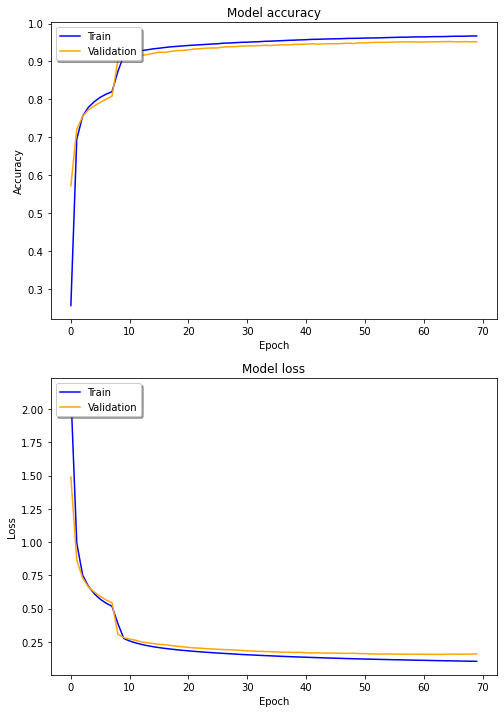

In [10]:
# write your code here
x= np.arange(0,len(train_acc))
fig = plt.figure(figsize=(8,12))
fig.subplots_adjust(hspace=0.2, wspace=0.2)
plt.subplot(2,1,1)
plt.plot(x, train_acc, color='Blue', label='Train')
plt.plot(x, test_acc, color='Orange', label='Validation')
plt.title('Model accuracy')
plt.xlabel("Epoch") 
plt.ylabel("Accuracy") 

plt.legend(loc='upper left', shadow=True) 

plt.subplot(2,1,2)
plt.plot(x, train_loss, color='Blue', label='Train')
plt.plot(x, test_loss, color='Orange', label='Validation')
plt.title('Model loss')
plt.xlabel("Epoch") 
plt.ylabel("Loss") 

plt.legend(loc='upper left', shadow=True) 